# 🦆 Training

✅ **needed to be checked**
- mixed precision (minor code refactoring done) ✅
- loss function (cross entropy loss and rce loss)
- collate (does it properly implemented?)
    - assumed torch padding function but was not used
- entity_extraction function
- does deverta accepted long sequence length even the config setted by 512 seq len?

✅ **needed to be added**
- training depend on device
- model output to prediction string converter
- f1macro calculation by prediction string
- training mode without gradient accumulation

---

- Environment Setting
- Argument Setting

## Environment Setting

In [1]:
import os
import os.path as osp
import sys

DATASET_PATH = ('../../feedback-prize-2021')

sys.path.insert(0, './codes')
sys.path.append('longformer/tvm/python/')
sys.path.append('longformer/')

In [46]:
import re
import random
import easydict
import argparse

from random import shuffle
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import ftfy
import dill as pickle
import wandb

import torch
from torch.utils.data import DataLoader

from transformers import DebertaV2Model

# torch.use_deterministic_algorithms(True)
# from longformer.longformer import Longformer, LongformerConfig, RobertaModel
# from longformer.sliding_chunks import pad_to_window_size

In [4]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

**why using `os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"`?**
- [torch.use_deterministic_algorithms](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html)
> **A handful of CUDA operations are nondeterministic if the CUDA version is 10.2 or greater**, unless the environment variable `CUBLAS_WORKSPACE_CONFIG=:4096:8` or `CUBLAS_WORKSPACE_CONFIG=:16:8` is set. See the CUDA documentation for more details: https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility If one of these environment variable configurations is not set, a RuntimeError will be raised from these operations when called with CUDA tensors:



## Argument Setting

In [23]:
def get_config():
    parser = argparse.ArgumentParser(description="use huggingface models")
    parser.add_argument("--wandb_user", default='ducky', type=str)
    parser.add_argument("--wandb_project", default='feedback_deberta_large', type=str)
    parser.add_argument("--dataset_path", default='../../feedback-prize-2021', type=str)
    parser.add_argument("--save_path", default='result', type=str)
    parser.add_argument("--seed", default=0, type=int)
    parser.add_argument("--min_len", default=0, type=int)
    parser.add_argument("--weight_decay", default=1e-2, type=float)
    parser.add_argument("--weights_pow", default=0.1, type=float)
    parser.add_argument("--use_groupped_weights", default=False, type=bool)
    parser.add_argument("--global_attn", default=False, type=int)
    parser.add_argument("--label_smoothing", default= 0.1, type=float)
    parser.add_argument("--extra_dense", default= False, type=bool)
    parser.add_argument("--epochs", default=9, type=int)
    parser.add_argument("--batch_size", default=4, type=int)
    parser.add_argument("--grad_acc_steps", default=2, type=int)
    parser.add_argument("--grad_checkpt", default=True, type=bool)
    parser.add_argument("--data_prefix", default='', type=str)
    parser.add_argument("--max_grad_norm", default=35 * 8, type=int)
    parser.add_argument("--start_eval_at", default=0, type=int)
    parser.add_argument("--lr", default=32e-6, type=float)
    parser.add_argument("--min_lr", default=32e-6, type=float)
    parser.add_argument("--dataset_version", default=2, type=int)
    parser.add_argument("--warmup_steps", default=500, type=int)
    parser.add_argument("--rce_weight", default=0.1, type=float)
    parser.add_argument("--ce_weight", default=0.9, type=float)
    parser.add_argument("--dropout_ratio", default=0.0, type=float)
    parser.add_argument("--decay_bias", default=False, type=bool)
    parser.add_argument("--val_fold", default=0, type=int)
    parser.add_argument("--num_worker", default=8, type=int)
    parser.add_argument("--model_name", default="microsoft/deberta-v3-large", type=str)
    parser.add_argument("--local_rank", type=int, default=-1, help="do not modify!")
    parser.add_argument("--device", type=int, default=0, help="select the gpu device to train")
    args = parser.parse_args(args=[])

    if args.local_rank !=-1:
        print('[ DDP ] local rank', args.local_rank)
        torch.cuda.set_device(args.local_rank)
        dist.init_process_group(backend='nccl')
        args.device = torch.device("cuda", args.local_rank)
        args.rank = torch.distributed.get_rank()
        args.world_size = torch.distributed.get_world_size()  

        # checking settings for distributed training
        assert args.batch_size % args.world_size == 0, f'--batch_size {args.batch_size} must be multiple of world size'
        assert torch.cuda.device_count() > args.local_rank, 'insufficient CUDA devices for DDP command'

        args.ddp = True
    else:
        args.device = torch.device("cuda")
        args.rank = 0
        args.ddp = False

    return args

## Load data

In [8]:
from module.utils import get_token_weights
from module.utils import get_prepare_data
from module.utils import get_all_texts
from module.utils import get_id_to_ix_map
from module.utils import get_fold_data

In [9]:
def get_data_files(args):
    token_weights = get_token_weights(args.use_groupped_weights, args.weights_pow)
    data = get_prepare_data()
    csv = pd.read_csv(osp.join(args.dataset_path, 'train.csv'))
    all_texts = get_all_texts(args)
    id_to_ix_map = get_id_to_ix_map()
    data_splits = get_fold_data()

    # text_id example `16585724607E`
    train_text_ids = [text_id for fold in range(5) if fold != args.val_fold for text_id in data_splits[args.seed][250]['normed'][fold]]
    val_text_ids = data_splits[args.seed][250]['normed'][args.val_fold]

    train_ids = [id_to_ix_map[text_id] for text_id in train_text_ids]
    val_ids = [id_to_ix_map[text_id] for text_id in val_text_ids]

    return all_texts, token_weights, data, csv, train_ids, val_ids, train_text_ids, val_text_ids

## Wandb

In [21]:
def wandb_setting(args):
    wandb.login()
    run = wandb.init(entity=args.wandb_user, project=args.wandb_project)
    run.name = f'v3_fold{args.val_fold}_minlr{args.min_lr}_maxlr{args.lr}_wd{args.weight_decay}_warmup{args.warmup_steps}_gradnorm{args.max_grad_norm}_biasdecay{args.decay_bias}_ls{args.label_smoothing}_wp{args.weights_pow}_data{args.dataset_version}_rce{args.rce_weight}'

## 🐣 Dataset & Dataloader

In [28]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, ids, data, label_smoothing, token_weights, data_prefix):
        self.ids = ids
        self.data = data
        self.label_smoothing = label_smoothing
        self.token_weights = token_weights
        self.data_prefix = data_prefix

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        i = self.ids[idx]

        # load train data
        tokens = self.data['tokens'][i]
        attention_mask = self.data['attention_masks'][i]
        num_tokens = self.data['num_tokens'][i, 0]

        # label smoothing
        cbio_labels = self.data[f'{self.data_prefix}cbio_labels'][i]
        cbio_labels *= (1 - self.label_smoothing)
        cbio_labels += self.label_smoothing / 15

        # class weight per token
        class_weight = np.zeros_like(attention_mask)
        argmax_labels = cbio_labels.argmax(-1)

        for class_i in range(1, 15):
            class_weight[argmax_labels == class_i] = self.token_weights[class_i]

        class_none_index = argmax_labels == 0      # 0 is the text that is not entity
        class_none_index[num_tokens - 1:] = False  # special token & padding
        class_weight[class_none_index] = self.token_weights[0]
        class_weight[0] = 0

        return tokens, attention_mask, cbio_labels, class_weight, num_tokens
    

In [29]:
class ValDataset(torch.utils.data.Dataset):
    def __init__(self, ids, data, csv, all_texts, val_text_ids, class_names, token_weights):
        self.ids = ids
        self.data = data
        self.csv = csv
        self.space_regex = re.compile('[\s\n]')
        self.all_texts = all_texts
        self.val_text_ids = val_text_ids
        self.class_names = class_names
        self.token_weights = token_weights

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        i = self.ids[idx]

        # load text data & text dataframe
        text_id = self.val_text_ids[idx]
        text = self.all_texts[text_id]
        sample_df = self.csv.query('id == @text_id')

        # load ground truth prediction string for f1macro metric
        gt_dict = {}
        for class_i in range(1, 8):
            class_name = self.class_names[class_i]
            class_df = sample_df.query('discourse_type == @class_name')   
            if len(class_df):
                gt_dict[class_i] = [(x[0], x[1]) for x in class_df.predictionstring.map(split_predstring)]
        
        # load valid data
        tokens = self.data['tokens'][i]
        attention_mask = self.data['attention_masks'][i]
        num_tokens = self.data['num_tokens'][i, 0]
        token_bounds = self.data['token_offsets'][i]
        cbio_labels = self.data['cbio_labels'][i]
        
        # class weight per token
        class_weight = np.zeros_like(attention_mask)
        argmax_labels = cbio_labels.argmax(-1)

        for class_i in range(1, 15):
            class_weight[argmax_labels == class_i] = self.token_weights[class_i]

        class_none_index = argmax_labels == 0
        class_none_index[num_tokens - 1:] = False
        class_weight[class_none_index] = self.token_weights[0]
        class_weight[0] = 0
        
        # ???
        index_map = []
        current_word = 0
        blank = False
        for char_ix in range(text.index(text.strip()[0]), len(text)):
            if self.space_regex.match(text[char_ix]) is not None:
                blank = True
            elif blank:
                current_word += 1
                blank = False
            index_map.append(current_word)
        
        return tokens, attention_mask, cbio_labels, class_weight, token_bounds, gt_dict, index_map, num_tokens

In [18]:
def get_dataloader(train_ids, val_ids, data, csv, all_texts, val_text_ids, class_names, token_weights, args):
    train_dataset = TrainDataset(train_ids, data, args.label_smoothing, token_weights, args.data_prefix)
    val_dataset = ValDataset(val_ids, data, csv, all_texts, val_text_ids, class_names, token_weights)

    train_dataloader = DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=args.batch_size, num_workers=args.num_worker)
    val_dataloader = DataLoader(val_dataset, collate_fn=val_collate_fn, batch_size=args.batch_size, num_workers=8, persistent_workers=True)

    return train_dataloader, val_dataloader

## Collate

In [33]:
first_batch = True
def train_collate_fn(ins):
    global first_batch
    if first_batch:
        max_len = 2048
        first_batch = False
    else:
        max_len = (max(x[-1] for x in ins) + 7) // 8 * 8
        
    return tuple(torch.from_numpy(np.concatenate([ins[z][x][None, :max_len] for z in range(len(ins))])) for x in range(len(ins[0]) - 1))
    
def val_collate_fn(ins):
    max_len = (max(x[-1] for x in ins) + 7) // 8 * 8
    return tuple(torch.from_numpy(np.concatenate([ins[z][x][None, :max_len] for z in range(len(ins))])) for x in range(len(ins[0]) - 3)) + ([x[-3] for x in ins], [x[-2] for x in ins], np.array([x[-1] for x in ins]),)

## 🧣 Model

In [60]:
class TvmLongformer(torch.nn.Module):
    """Currently microsoft/deberta-v3-large"""
    def __init__(self, args):
        super().__init__()
        self.args = args

        self.feats = DebertaV2Model.from_pretrained('microsoft/deberta-v3-large')
        self.feats.pooler = None

        if args.grad_checkpt:
            self.feats.gradient_checkpointing_enable()

        self.feats.train()

        self.conv1d_layer1 = torch.nn.Conv1d(1024, 1024, kernel_size=1)
        self.conv1d_layer3 = torch.nn.Conv1d(1024, 1024, kernel_size=3, padding=1)
        self.conv1d_layer5 = torch.nn.Conv1d(1024, 1024, kernel_size=5, padding=2)

        if args.extra_dense:
            self.class_projector = torch.nn.Sequential(
                torch.nn.LayerNorm(1024*3),
                torch.nn.Linear(1024*3, 256),
                torch.nn.GELU(),
                torch.nn.Linear(256, 15)
            )
        else:
            self.class_projector = torch.nn.Sequential(
                torch.nn.LayerNorm(1024*3),
                torch.nn.Linear(1024*3, 15)
            )
    def forward(self, tokens, mask):
        transformer_output = self.feats(tokens, mask, return_dict=False)[0]
        conv_input = transformer_output.transpose(1, 2) # batch, hidden, seq

        conv_output1 = F.relu(self.conv1d_layer1(conv_input)) 
        conv_output3 = F.relu(self.conv1d_layer3(conv_input)) 
        conv_output5 = F.relu(self.conv1d_layer5(conv_input)) 

        concat_output = torch.cat((conv_output1, conv_output3, conv_output5), dim=1).transpose(1, 2)

        output = self.class_projector(concat_output)
        return torch.log_softmax(output, -1)

In [62]:
def get_model(args, train_dataloader):
    model = TvmLongformer(args).to(args.device)

    # dropout layer
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.p = args.dropout_ratio

    # ...
    weights = []
    biases = []
    for n, p in model.named_parameters():
        if n.startswith('feats.embeddings') or 'LayerNorm' in n or n.endswith('bias'):
            # embedding layer & bias layer
            biases.append(p)
        else:
            # except above
            weights.append(p)

    optimizer = torch.optim.AdamW([{'params': weights, 'weight_decay': args.weight_decay, 'lr': 0},
                                   {'params': biases, 'weight_decay': 0 if not args.decay_bias else args.weight_decay, 'lr': 0}])

    lr_schedule = np.r_[np.linspace(0, args.lr, args.warmup_steps),
                    (np.cos(np.linspace(0, np.pi, len(train_dataloader)*args.epochs - args.warmup_steps)) * .5 + .5) * (args.lr - args.min_lr)
                    + args.min_lr]
    
    return model, optimizer, lr_schedule


## 🚵🏻 Main

In [25]:
seed_everything(42)
args = get_config()
# wandb_setting(args)

class_names = ['None',
               'Lead',
               'Position',
               'Evidence',
               'Claim',
               'Concluding Statement',
               'Counterclaim',
               'Rebuttal']

# create directory to save model
if not osp.exists(args.save_path):
    os.makedirs(args.save_path)


In [27]:
args

Namespace(batch_size=4, ce_weight=0.9, data_prefix='', dataset_path='../../feedback-prize-2021', dataset_version=2, ddp=False, decay_bias=False, device=device(type='cuda'), dropout_ratio=0.0, epochs=9, extra_dense=False, global_attn=False, grad_acc_steps=2, grad_checkpt=True, label_smoothing=0.1, local_rank=-1, lr=3.2e-05, max_grad_norm=280, min_len=0, min_lr=3.2e-05, model_name='microsoft/deberta-v3-large', num_worker=8, rank=0, rce_weight=0.1, save_path='result', seed=0, start_eval_at=0, use_groupped_weights=False, val_fold=0, wandb_project='feedback_deberta_large', wandb_user='ducky', warmup_steps=500, weight_decay=0.01, weights_pow=0.1)

In [34]:
all_texts, token_weights, data, csv, train_ids, val_ids, train_text_ids, val_text_ids = get_data_files(args)
train_dataloader, val_dataloader = get_dataloader(train_ids, val_ids, data, csv, all_texts, val_text_ids, class_names, token_weights, args)

In [42]:
for tokens, attention_mask, cbio_labels, class_weight in train_dataloader:
    print(tokens)
    break

tensor([[    1,  1258,   355,  ...,     0,     0,     0],
        [    1, 10147,  6654,  ...,     0,     0,     0],
        [    1,   279,  1574,  ...,     0,     0,     0],
        [    1, 10147,   565,  ...,     0,     0,     0]])


In [65]:
for tokens, attention_mask, cbio_labels, class_weight in train_dataloader:
    print(tokens)
    break

tensor([[    1,  1258,   355,  ...,     0,     0,     0],
        [    1, 10147,  6654,  ...,     0,     0,     0],
        [    1,   279,  1574,  ...,     0,     0,     0],
        [    1, 10147,   565,  ...,     0,     0,     0]])


In [63]:
model, optimizer, lr_schedule = get_model(args, train_dataloader)

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [64]:
model

TvmLongformer(
  (feats): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
             

# Test Laboratory

In [ ]:
STOP!!!! YOU SHALL NOT PASS!!!

## scheduler

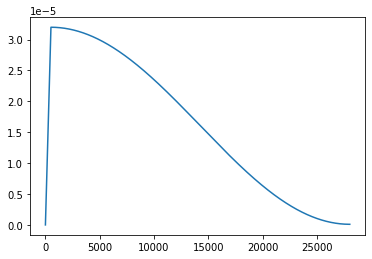

In [56]:
args.min_lr = 1e-07

lr_schedule = np.r_[np.linspace(0, args.lr, args.warmup_steps),
                    (np.cos(np.linspace(0, np.pi, len(train_dataloader)*args.epochs - args.warmup_steps)) * .5 + .5) * (args.lr - args.min_lr)
                    + args.min_lr]

plt.plot(np.arange(len(lr_schedule)), lr_schedule)
plt.show()